<a href="https://colab.research.google.com/github/marah-ghanem/Waste_Classification_Project/blob/main/Waste_Classification_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mareh Aboghanem

**WASTE CLASSIFICATION**
PROBLEM
Waste management is a big problem in our country. Most of the wastes end up in landfills. This leads to many issues like:

*   Increase in landfills
*   Eutrophication
*   Consumption of toxic waste by animals.
*   Leachate.
*   Increase in toxinsLand.
*   water and air pollution.


# Load The Dataset & Preprocessing :

### IMPORT LIBRARIES

In [1]:
!pip install Keras-Preprocessing
#!pip install tensorflow
import os
import glob
import shutil
import random
import numpy as np
import skimage.io
import tensorflow
from PIL import Image
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage.io import imshow
from tensorflow.keras.models import Sequential
from keras_preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import InputLayer, Dense, Flatten, BatchNormalization, Dropout, Activation

%matplotlib inline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.7 MB/s eta 0:00:00


### Load DATASET

Dataset is divided into train data (85%) and test data (15%)

*   Training data - 22564 images
*   Test data - 2513 images




In [2]:
! pip install opendatasets
import opendatasets as od
od.download("https://www.kaggle.com/datasets/techsash/waste-classification-data")

100%|██████████| 427M/427M [00:05<00:00, 85.9MB/s]


In [3]:
data ='/content/waste-classification-data/dataset/DATASET'
train_data_dir = '/content/waste-classification-data/dataset/DATASET/TRAIN'
test_data_dir = '/content/waste-classification-data/dataset/DATASET/TEST'

There is imbalance between the Two Classes [O,R] so I did
data augmentation:



---


1. UpSampling :Balance the 'recycle' class with the 'organic' class by

adding randomly selected 'recycle' samples to reach 12,565 samples.




---

In [4]:
original_Class_R = '/content/waste-classification-data/DATASET/TRAIN/R'
augmented_Class_R = '/content/waste-classification-data/DATASET/TRAIN/R'
os.makedirs(augmented_Class_R, exist_ok=True)
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
original_image_R_file =[os.path.join(original_Class_R, filename) for filename in os.listdir(original_Class_R)]
addi_img_needed = 12565 - len(original_image_R_file)
for i in range(addi_img_needed):
    random_originalR_img = random.choice(original_image_R_file)
    img = load_img(random_originalR_img)
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)
    for batch in datagen.flow(x, batch_size=1):
        augmented_img = batch[0].astype('uint8')
        new_image_path = os.path.join(augmented_Class_R, f'augmented_image_{i}.jpg')
        img_to_save = Image.fromarray(augmented_img)
        img_to_save.save(new_image_path)
        break
print(f"total in augmented: {len(os.listdir(augmented_Class_R))}")

total in augmented: 12565


In [5]:
Class_R = '/content/waste-classification-data/DATASET/TRAIN/R/'
file_extension = '*.jpg'
match_img = glob.glob(os.path.join(Class_R, file_extension))
num_Class_R = len(match_img)
num_Class_R

12565



---


2. Preprocess dataset by rescaling pixel values, applying zoom and rotation transformations, and adding horizontal and vertical flips. Also, split the dataset into training and validation sets with an 80-20 split ratio.



---

In [6]:
classes = ['O','R']
new_height = 224
new_width = 224
batch_size = 128

In [7]:
param = {
    "rescale": 1.0 / 255.0,
    "zoom_range": 0.4,
    "rotation_range": 10,
    "horizontal_flip": True,
    "vertical_flip": True,
    "validation_split": 0.2,
}

In [8]:
train_pp_aug = ImageDataGenerator(**param)

In [9]:
train_generator = train_pp_aug.flow_from_directory(
    train_data_dir,
    target_size=(new_height, new_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

Found 18052 images belonging to 2 classes.


In [10]:
vaild_param = {
    "rescale": 1.0 / 255.0,
    "validation_split": 0.2,
}

In [11]:
valid_pp = ImageDataGenerator(**vaild_param)

In [12]:
validation_generator = valid_pp.flow_from_directory(
    train_data_dir,
    target_size=(new_height, new_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

Found 4512 images belonging to 2 classes.


In [13]:
test_pp = ImageDataGenerator(rescale=1.0/255.0)

In [14]:
test_generator = test_pp.flow_from_directory(
    test_data_dir,
    target_size=(new_height, new_width),
    batch_size=batch_size,
    class_mode='binary'
)

Found 2513 images belonging to 2 classes.


# MODEL

This model is a fine-tuned VGG16-based convolutional neural network (CNN) with custom 5 dense layers (1024, 512, and 256 filters) incorporating batch normalization, ReLU activation, and dropout (20% rate). It is designed for binary waste classification tasks.

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [52]:
VGG16_model = VGG16(input_shape=(new_height,new_width,3),include_top=False,weights="imagenet")
for layer in VGG16_model.layers:
    layer.trainable=False

In [67]:
model=Sequential()
model.add(VGG16_model)
model.add(Dropout(0.2))

model.add(Flatten())

model.add(BatchNormalization())
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(512,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(256,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(512,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(512,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(1,activation='sigmoid'))

model.load_weights('/content/drive/MyDrive/lastw.h5')

In [56]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 dropout_30 (Dropout)        (None, 7, 7, 512)         0         
                                                                 
 flatten_5 (Flatten)         (None, 25088)             0         
                                                                 
 batch_normalization_25 (Ba  (None, 25088)             100352    
 tchNormalization)                                               
                                                                 
 dense_30 (Dense)            (None, 1024)              25691136  
                                                                 
 activation_25 (Activation)  (None, 1024)              0         
                                                      

In [68]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC


optimizer = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy',metrics=[AUC(name='auc')],optimizer=optimizer)


In [21]:
filepath = './best_weights.hdf5'

earlystopping = EarlyStopping(monitor = 'val_auc',
                              mode = 'max' ,
                              patience = 4,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath,
                                monitor = 'val_auc',
                                mode='max',
                                save_best_only=True,
                                verbose = 1)

In [22]:
model_history=model.fit(train_generator,validation_data=validation_generator,epochs = 20,callbacks =[earlystopping, checkpoint],verbose = 1)

Epoch 1/20
142/142 [==============================] - ETA: 0s - loss: 0.1112 - auc: 0.9919
Epoch 1: val_auc improved from -inf to 0.94776, saving model to ./best_weights.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


142/142 [==============================] - 310s 2s/step - loss: 0.1112 - auc: 0.9919 - val_loss: 0.3936 - val_auc: 0.9478
Epoch 2/20
142/142 [==============================] - ETA: 0s - loss: 0.1036 - auc: 0.9928
Epoch 2: val_auc improved from 0.94776 to 0.95450, saving model to ./best_weights.hdf5
142/142 [==============================] - 273s 2s/step - loss: 0.1036 - auc: 0.9928 - val_loss: 0.3562 - val_auc: 0.9545
Epoch 3/20
142/142 [==============================] - ETA: 0s - loss: 0.1041 - auc: 0.9928
Epoch 3: val_auc did not improve from 0.95450
142/142 [==============================] - 275s 2s/step - loss: 0.1041 - auc: 0.9928 - val_loss: 0.3150 - val_auc: 0.9483
Epoch 4/20
142/142 [==============================] - ETA: 0s - loss: 0.1015 - auc: 0.9930
Epoch 4: val_auc improved from 0.95450 to 0.95836, saving model to ./best_weights.hdf5
142/142 [==============================] - 280s 2s/step - loss: 0.1015 - auc: 0.9930 - val_loss: 0.3416 - val_auc: 0.9584
Epoch 5/20
142/142 

In [23]:
import shutil
model.save_weights('modelw.h5')
shutil.copy("modelw.h5","/content/drive/MyDrive/")

'/content/drive/MyDrive/modelw.h5'

## MODEL EVALUATION

In [69]:
model.evaluate(test_generator)

20/20 [==============================] - 11s 541ms/step - loss: 0.2976 - auc: 0.9559


[0.29755938053131104, 0.9558748006820679]

In [27]:
test_predictions = model.predict(test_generator)

20/20 [==============================] - 11s 547ms/step


In [41]:
test_labels=[]
test_paths = []

In [42]:
def loading_preprocessing_ImagePerdict(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, (new_height, new_width))
    return image

In [43]:
tst_predictions = np.array(test_predictions)
threshold = 0.5
test_predictions = (tst_predictions > threshold).astype(np.int32)

for class_name in classes:
    class_dir = os.path.join(test_data_dir, class_name)
    for filename in os.listdir(class_dir):
        test_paths.append(os.path.join(class_dir, filename))
        test_labels.append(classes.index(class_name))
test_labels = np.array(test_labels)


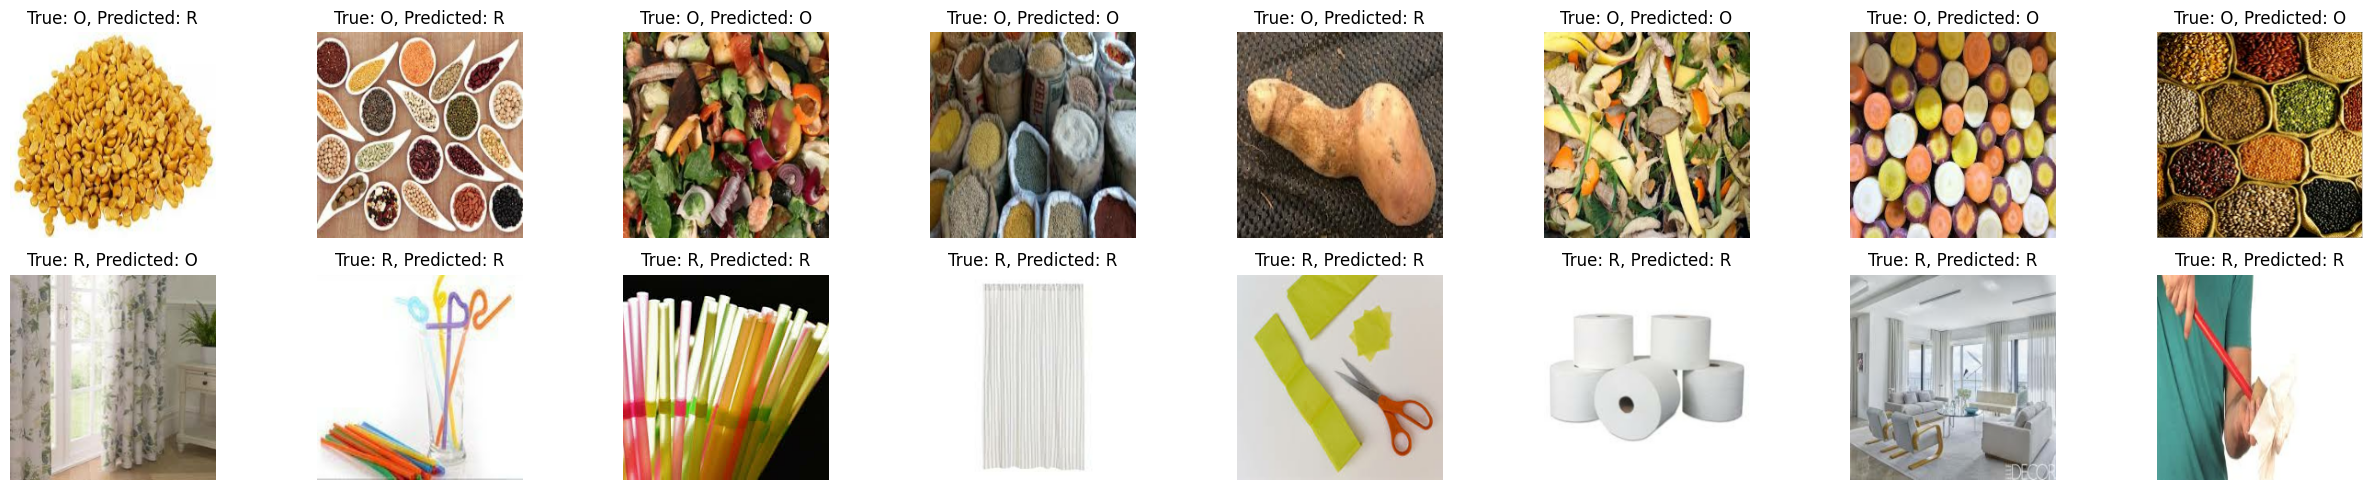

In [48]:
num_img = 8
plt.figure(figsize=(25, 5))

for class_label in [0, 1]:
    class_indices = np.where(test_labels == class_label)[0][:num_img]
    for i, index in enumerate(class_indices):
        image_path = test_paths[index]
        true_label = test_labels[index]
        predicted_label = test_predictions[index]
        image = loading_preprocessing_ImagePerdict(image_path)
        plt.subplot(2,num_img , class_label * num_img + i + 1)
        plt.imshow(image.numpy())
        P='O' if predicted_label==0 else 'R'
        T='O' if true_label==0 else 'R'
        plt.title(f"True: {T}, Predicted: {P}")
        plt.axis("off")

plt.tight_layout()
plt.show()

##Test it on Real data

1/1 [==============================] - 1s 994ms/step
Organic waste


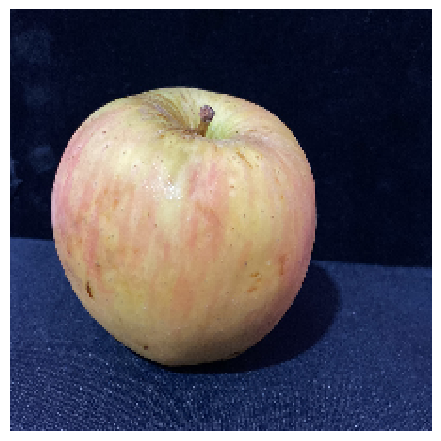

In [49]:
# Test Case:1 - ORGANIC

dic = test_generator.class_indices
idc = {k:v for v,k in dic.items()}

img = load_img('/content/drive/MyDrive/apple.png', target_size=(224,224))
img = img_to_array(img)
img = img / 255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)

def predict_prob(number):
  return [number[0],1-number[0]]

answer = np.array(list(map(predict_prob, model.predict(img))))
if answer[0][0] > 0.5:
    print("Recycle waste")
else:
    print("Organic waste")

1/1 [==============================] - 0s 25ms/step
Recycle waste


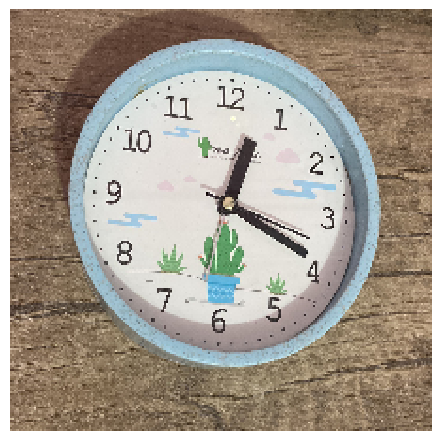

In [50]:
dic = test_generator.class_indices
idc = {k:v for v,k in dic.items()}

img = load_img('/content/drive/MyDrive/watch.png', target_size=(224,224))
img = img_to_array(img)
img = img / 255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)

def predict_prob(number):
  return [number[0],1-number[0]]

answer = np.array(list(map(predict_prob, model.predict(img))))
if answer[0][0] > 0.5:
    print("Recycle waste")
else:
    print("Organic waste")